# [WIP] {{domain_name}}: (DIC, ALK)
**Compare simulated DIC and Alkalinity fields to observationally-based data**

This notebook is intended to evaluate model skill by comparing simulated Dissolved Inorganic Carbon (DIC) and Total Alkalinity (ALK) fields against GLODAP observational products. The analysis focuses on spatial patterns and summary metrics that highlight biases relative to the GLODAP climatology.


In [1]:
%load_ext autoreload
%autoreload 2
from glob import glob
from pathlib import Path

import numpy as np
import xarray as xr

import xesmf

import cson_forge
from cson_forge.diagnostics import glodap


In [ ]:
domain_name = "CCS-12km"
model_name = "cson_roms-marbl_v0.1"
grid_name = "ccs-12km"
dask_cluster_kwargs = {
    "account": "m4632",
    "queue_name": "premium",
    "n_nodes": 1,
    "n_tasks_per_node": 128,
    "wallclock": "06:00:00",
    "scheduler_file": None,
}


In [3]:
df = cson_forge.catalog.blueprint.load(stage="run")
df = df.loc[(df.grid_name == grid_name) & (df.model_name == model_name)]

if df.empty:
    raise ValueError(
        f"No blueprint found: model_name='{model_name}'; grid_name='{grid_name}' "
        f"at stage='run'"
    )

df

,model_name,grid_name,blueprint_name,description,start_time,end_time,blueprint_path,grid_yaml_path,stage
0,cson_roms-marbl_v0.1,ccs-12km,cson_roms-marbl_v0.1_ccs-12km,California Current System,2024-01-01T00:00:00,2024-01-02T00:00:00,/Users/mclong/codes/cson-forge/cson_forge/blue...,/Users/mclong/codes/cson-forge/cson_forge/blue...,run


In [4]:
blueprint_path = df.blueprint_path.iloc[0]
casename = blueprint_path.stem.replace("B_", "") # get less janky
simulation_dir = Path(cson_forge.config.paths.scratch / casename)

print(f"Blueprint path: {blueprint_path}")
print(f"Simulation directory: {simulation_dir}")

# TODO: make this less janky
pattern = "output_bgc_dia.*"
files = glob(str(simulation_dir / "output" / "joined_output" / pattern))
print(f"Found {len(files)} files matching pattern '{pattern}'")
if files:
    print(f"First file: {Path(files[0]).name}")
    if len(files) > 1:
        print(f"Last file: {Path(files[-1]).name}")
        print(f"All files: {[Path(f).name for f in sorted(files)]}")
else:
    print("No files found!")

Blueprint path: /Users/mclong/codes/cson-forge/cson_forge/blueprints/cson_roms-marbl_v0.1_ccs-12km/B_cson_roms-marbl_v0.1_ccs-12km_run_20240101-20240102.yml
Simulation directory: /Users/mclong/cson-forge-data/cson-forge-run/cson_roms-marbl_v0.1_ccs-12km_run_20240101-20240102
Found 1 files matching pattern 'output_bgc_dia.*'
First file: output_bgc_dia.20120101000000.0.nc


Reading grid file:
 /Users/mclong/codes/cson-forge/cson_forge/blueprints/cson_roms-marbl_v0.1_ccs-12km/_grid.yml


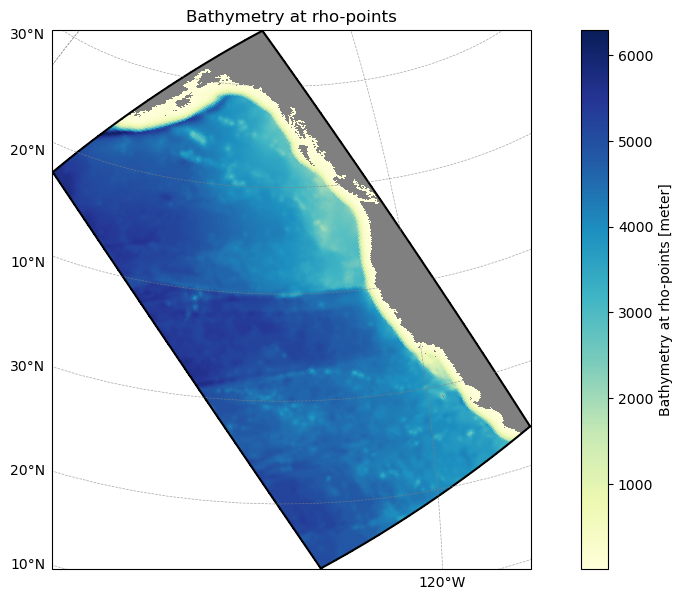

In [5]:
domain_name = f"{model_name}_{grid_name}"

grid_yaml = Path(df.grid_yaml_path.iloc[0])
print("Reading grid file:\n", grid_yaml)

grid_obj = cson_forge.parsers.load_roms_tools_object(grid_yaml)
grid = grid_obj.ds
grid_obj.plot();

In [6]:
ds = glodap.open_glodap(product='GLODAPv2.2016b_MappedClimatologies')
# subset for surface
ds = ds.isel(depth=0, drop=True)

# Regrid GLODAP data to model grid using xesmf (grid loaded from cell above)

# Create source grid (GLODAP) - 2D lon/lat for xesmf
lon_2d, lat_2d = np.meshgrid(ds.lon.values, ds.lat.values)
ds_source = xr.Dataset(
    {"lon": (("lat", "lon"), lon_2d), "lat": (("lat", "lon"), lat_2d)}
)

# Create destination grid (model grid)
ds_target = xr.Dataset(
    {
        "lon": (("eta_rho", "xi_rho"), grid.lon_rho.values),
        "lat": (("eta_rho", "xi_rho"), grid.lat_rho.values),
    }
)

# Build regridder (bilinear, periodic for global data)
regridder = xesmf.Regridder(
    ds_source, ds_target, method="bilinear", periodic=True
)

# Variables to regrid (exclude coords and derived)
skip_vars = ["lon", "lat", "area", "depth_bnds", "dz"]
vars_to_regrid = [v for v in ds.data_vars if v not in skip_vars]
ds_to_regrid = ds[vars_to_regrid]

# Regrid
ds_regridded = regridder(ds_to_regrid)

# Add model grid coordinates and copy attributes
ds_regridded = ds_regridded.assign_coords(
    lon_rho=(("eta_rho", "xi_rho"), grid.lon_rho.values),
    lat_rho=(("eta_rho", "xi_rho"), grid.lat_rho.values),
)
for v in ds_regridded.data_vars:
    if v in ds.data_vars:
        ds_regridded[v].attrs.update(ds[v].attrs)
ds_regridded.attrs.update(ds.attrs)

ds = ds_regridded
print("GLODAP data regridded to model grid using xesmf (bilinear, periodic)")

ds

/Users/mclong/.local/share/mamba/envs/cson-forge-v0/lib/python3.13/site-packages/xesmf/backend.py:42: UserWarning: Input array is not F_CONTIGUOUS. Will affect performance.
  warnings.warn('Input array is not F_CONTIGUOUS. ' 'Will affect performance.')


GLODAP data regridded to model grid using xesmf (bilinear, periodic)


<xarray.Dataset> Size: 13MB
Dimensions:       (eta_rho: 442, xi_rho: 226)
Coordinates:
    lon_rho       (eta_rho, xi_rho) float64 799kB 228.0 228.1 ... 219.4 219.6
    lat_rho       (eta_rho, xi_rho) float64 799kB 13.18 13.23 ... 65.84 65.9
Dimensions without coordinates: eta_rho, xi_rho
Data variables: (12/14)
    Cant          (eta_rho, xi_rho) float64 799kB 65.32 65.3 65.28 ... nan nan
    NO3           (eta_rho, xi_rho) float64 799kB 0.1693 0.1685 ... nan nan
    OmegaA        (eta_rho, xi_rho) float64 799kB 3.417 3.414 3.411 ... nan nan
    OmegaC        (eta_rho, xi_rho) float64 799kB 5.175 5.171 5.167 ... nan nan
    PI_TCO2       (eta_rho, xi_rho) float64 799kB 1.862e+03 1.863e+03 ... nan
    PO4           (eta_rho, xi_rho) float64 799kB 0.217 0.2179 ... nan nan
    ...            ...
    O2            (eta_rho, xi_rho) float64 799kB 208.1 208.1 208.1 ... nan nan
    pHts25p0      (eta_rho, xi_rho) float64 799kB 8.082 8.082 8.081 ... nan nan
    pHtsinsitutp  (eta_rho, xi_rho) float64 799kB 8.065 8.065 8.065 ... nan nan
    SALT          (eta_rho, xi_rho) float64 799kB 34.31 34.32 34.32 ... nan nan
    SiO3          (eta_rho, xi_rho) float64 799kB 2.631 2.626 2.623 ... nan nan
    TEMP          (eta_rho, xi_rho) float64 799kB 26.43 26.39 26.35 ... nan nan
Attributes:
    regrid_method:        bilinear
    Description:          1 X 1 global mapped field of anthropogenic carbon c...
    Created:              Created by Siv K. Lauvset on 12-May-2016 18:48:16
    Institution name:     University of Bergen
    Contact information:  siv.lauvset@uib.no; are.olsen@uib.no
    Citation:             Cite as: Lauvset, Siv K., Key, Robert M., Olsen, Ar...

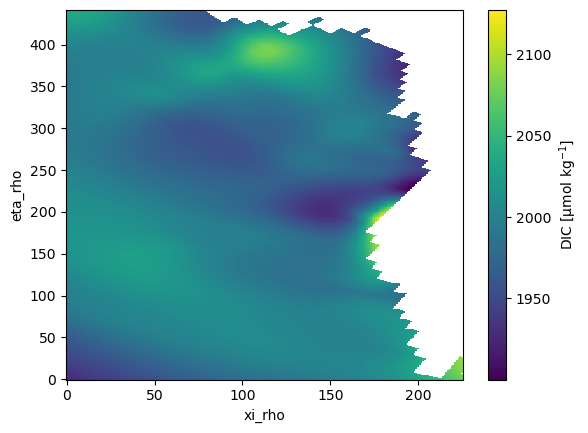

In [7]:
ds.DIC.plot();

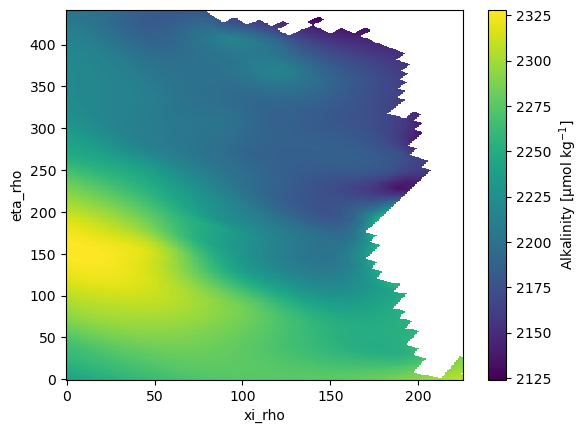

In [8]:
ds.ALK.plot();